<a href="https://colab.research.google.com/github/kinghoon/Deep-Learning-for-project/blob/main/%EC%8B%A4%ED%97%98%EC%8B%A43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shape: (3751, 20, 431)
Class labels: ['2', '1', '3', '4']
Class distribution: {'2': 1537, '1': 294, '3': 1194, '4': 726}


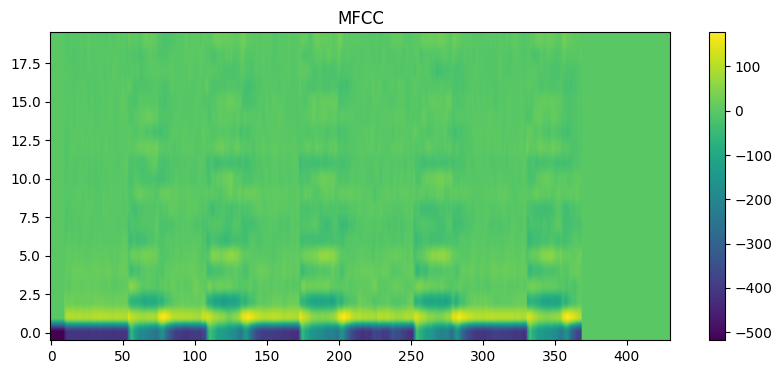

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5596 - loss: 1.0568 - val_accuracy: 0.4663 - val_loss: 1.5222
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7909 - loss: 0.5102 - val_accuracy: 0.6812 - val_loss: 0.9698
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8274 - loss: 0.4237 - val_accuracy: 0.8126 - val_loss: 0.4641
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8138 - loss: 0.4893 - val_accuracy: 0.8428 - val_loss: 0.3971
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8232 - loss: 0.4326 - val_accuracy: 0.8588 - val_loss: 0.3603
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8525 - loss: 0.3692 - val_accuracy: 0.8774 - val_loss: 0.2936
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9031 - loss: 0.2399 - val_accuracy: 0.8837 - val_loss: 0.2935
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8882 - loss: 0.3115 - val_accuracy: 0.9067 - v

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy4',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/add_noise',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/change_speed',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/pitch_shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/time_stretch',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid4',
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs, sr=22050):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs, sr=sr)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # CNN은 4D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# CRNN 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(n_mfcc, fixed_sequence_length, 1)),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),

    layers.Reshape((fixed_sequence_length // 8, (n_mfcc // 8) * 128)),  # CNN의 출력을 RNN의 입력으로 재구성
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# 학습 후 모델 저장
# model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/0613_analyzer_crnn.keras')


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/0615_LAST(3124).keras')

NameError: name 'model' is not defined

# 학습률감소

Data shape: (3751, 20, 431)
Class labels: ['2', '1', '3', '4']
Class distribution: {'2': 1537, '1': 294, '3': 1194, '4': 726}


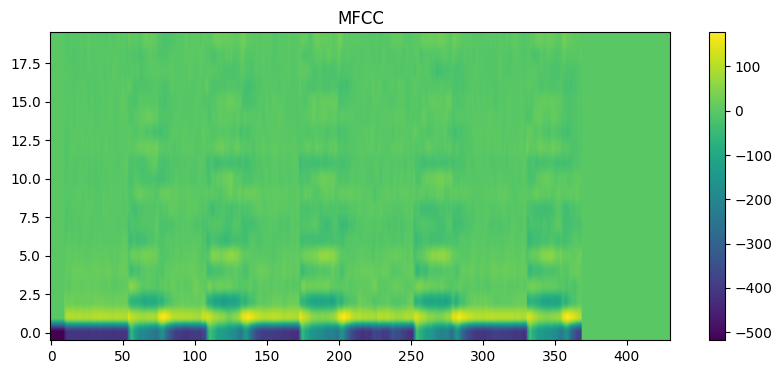

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.5607 - loss: 1.0102 - val_accuracy: 0.8032 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7808 - loss: 0.5113 - val_accuracy: 0.8590 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8171 - loss: 0.4358 - val_accuracy: 0.8830 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8461 - loss: 0.3624 - val_accuracy: 0.8883 - val_loss: 0.2577 - learning_rate: 0.0010
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8544 - loss: 0.3322 - val_accuracy: 0.8936 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8840 - loss: 0.2737 - val_accuracy: 0.8803 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9156 - loss: 0.

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy4',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/add_noise',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/change_speed',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/pitch_shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/time_stretch',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid4',
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs, sr=22050):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs, sr=sr)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # CNN은 4D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# CRNN 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(n_mfcc, fixed_sequence_length, 1)),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.3),  # 드롭아웃 추가

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.3),  # 드롭아웃 추가

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.3),  # 드롭아웃 추가

    layers.Reshape((fixed_sequence_length // 8, (n_mfcc // 8) * 128)),  # CNN의 출력을 RNN의 입력으로 재구성
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정 및 학습률 감소 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/0615_(2413,0.1,Drop2).keras')

In [ ]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import os
import shutil

def move_and_rename_files(source_directory, destination_directory, start_number=250):
    # 소스 디렉토리에서 파일 목록 가져오기
    files = os.listdir(source_directory)

    # 시작 번호 설정
    current_number = start_number

    # 파일 이동 및 이름 변경
    for file_name in files:
        # 원본 파일 경로
        source_file = os.path.join(source_directory, file_name)

        # 새로운 파일 이름 설정
        new_file_name = f"2({current_number}).wav"
        destination_file = os.path.join(destination_directory, new_file_name)

        # 파일 이동
        shutil.move(source_file, destination_file)

        # 번호 증가
        current_number += 1

# 예제 사용법
source_directory = '/content/drive/MyDrive/Colab Notebooks/voicedata/Covid_kh/segmented/neg'  # 원본 파일 경로
destination_directory = '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT'  # 이동할 경로

# 경로가 존재하지 않으면 생성
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# 파일 이동 및 이름 변경 실행
move_and_rename_files(source_directory, destination_directory)


In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

Data shape: (4223, 20, 431)
Class labels: ['2', '3', '4', '1']
Class distribution: {'2': 1813, '3': 1194, '4': 726, '1': 490}


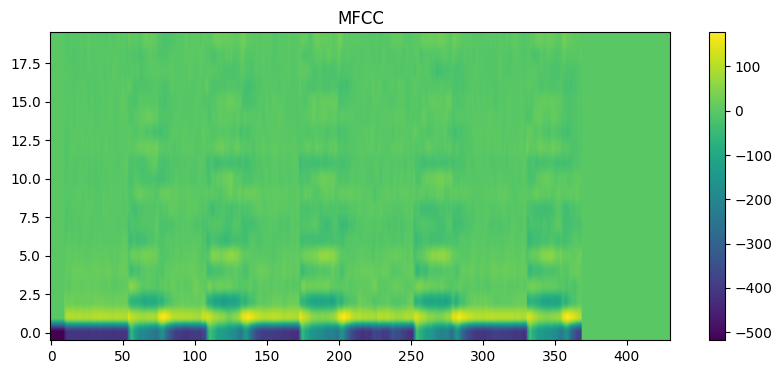

Epoch 1/20
119/119 [==============================] - 149s 1s/step - loss: 1.0138 - accuracy: 0.5600 - val_loss: 0.6405 - val_accuracy: 0.7470
Epoch 2/20
119/119 [==============================] - 141s 1s/step - loss: 0.5730 - accuracy: 0.7729 - val_loss: 0.4701 - val_accuracy: 0.8061
Epoch 3/20
119/119 [==============================] - 131s 1s/step - loss: 0.4661 - accuracy: 0.8108 - val_loss: 0.4449 - val_accuracy: 0.8085
Epoch 4/20
119/119 [==============================] - 132s 1s/step - loss: 0.3976 - accuracy: 0.8363 - val_loss: 0.3316 - val_accuracy: 0.8440
Epoch 5/20
119/119 [==============================] - 134s 1s/step - loss: 0.3474 - accuracy: 0.8582 - val_loss: 0.3496 - val_accuracy: 0.8723
Epoch 6/20
119/119 [==============================] - 131s 1s/step - loss: 0.2768 - accuracy: 0.8832 - val_loss: 0.3643 - val_accuracy: 0.8534
Epoch 7/20
14/14 [==============================] - 3s 227ms/step - loss: 0.3316 - accuracy: 0.8440
Test accuracy: 0.8439716100692749


In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import random
import tensorflow as tf

# 랜덤 시드 설정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy4',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy5',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/augmented(1)',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/add_noise',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/change_speed',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/pitch_shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/time_stretch',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid4',
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs, sr=22050):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs, sr=sr)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # CNN은 4D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

# 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(n_mfcc, fixed_sequence_length, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Reshape((fixed_sequence_length // 8, (n_mfcc // 8) * 128)),
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/0618_batchmax().keras')


# 0616 학습

In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 새 오디오 파일 로드 및 MFCC 변환
def extract_mfcc(file_path, sr=22050, duration=10):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if mfcc.shape[1] < fixed_sequence_length:
        pad_width = fixed_sequence_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_sequence_length]

    return mfcc

# 예측 함수
def predict(model, file_path, class_labels):
    mfcc = extract_mfcc(file_path, sr=sr, duration=duration)
    X = np.expand_dims(mfcc, axis=-1)
    X = np.expand_dims(X, axis=0)  # 배치 차원 추가

    predictions = model.predict(X)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_probabilities = predictions[0]

    return predicted_class[0], predicted_probabilities

# 디렉토리의 모든 파일에 대해 예측 수행
def predict_directory(model, directory, class_labels):
    files = [file for file in os.listdir(directory) if file.endswith('.wav')]
    total_files = len(files)
    results = []
    class_counts = {label: 0 for label in class_labels}
    class_probabilities = {label: [] for label in class_labels}

    for idx, file_name in enumerate(files):
        file_path = os.path.join(directory, file_name)
        predicted_class, predicted_probabilities = predict(model, file_path, class_labels)
        results.append((file_name, predicted_class, predicted_probabilities))

        # 예측 결과 저장
        class_label = class_labels[predicted_class]
        class_counts[class_label] += 1
        for i, label in enumerate(class_labels):
            class_probabilities[label].append(predicted_probabilities[i])

        # 예측 결과 출력
        print(f'1/1 [==============================] - 0s')
        print(f'File: {file_name}')
        print(f'Predicted label: {class_label}')
        print(f'Predictions: {predicted_probabilities}')
        print('---')

    return results, class_counts, class_probabilities

# 통계 출력 함수
def print_statistics(class_counts, class_probabilities):
    total_predictions = sum(class_counts.values())
    print('\nPrediction Statistics:')
    for label in class_counts:
        percentage = (class_counts[label] / total_predictions) * 100
        print(f'{label}: {class_counts[label]} ({percentage:.2f}%)')

# 저장된 모델 로드
model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/0616_batchmax(1243).keras')

# 클래스 레이블 정의
class_labels = ['천식', '정상', '심부전', '코로나']  # 실제 클래스 라벨을 여기에 입력하세요

# 예측을 위한 디렉토리 경로
predict_directory_path = '/content/drive/MyDrive/Colab Notebooks/voicedata/covid5'

# 디렉토리 내 모든 파일에 대해 예측 수행
predictions, class_counts, class_probabilities = predict_directory(model, predict_directory_path, class_labels)

# 전체 통계 출력
print_statistics(class_counts, class_probabilities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 [==============================] - 0s
File: 3(250).wav
Predicted label: 코로나
Predictions: [7.5588714e-06 8.6159863e-02 1.9484329e-03 9.1188413e-01]
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 [==============================] - 0s
File: 3(255).wav
Predicted label: 코로나
Predictions: [0.0190082  0.08057595 0.00558517 0.89483064]
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 [==============================] - 0s
File: 3(260).wav
Predicted label: 코로나
Predictions: [9.8024457e-06 3.4563139e-01 8.8848947e-03 6.4547384e-01]
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 [==============================] - 0s
File: 3(265).wav
Predicted label: 코로나
Predictions: [7.5968765e-06 5.3127591e-02 1.3654388e-03 9.4549942e-01]
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 [==============================] - 0s
File: 3(270).wav
Predicted label: 코로나
Predictions: [1.3826866e-04 2.0728287e-01 1.5322406e-02 7.7725637e-01]
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 [====

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
 '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy3',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy4',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/add_noise',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/change_speed',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/pitch_shift',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/shift',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/time_stretch',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/covid3',
 '/content/drive/MyDrive/Colab Notebooks/voicedata/covid4',
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs, sr=22050):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs, sr=sr)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # CNN은 4D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 하이퍼파라미터 탐색을 위한 모델 빌드 함수
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
        activation='relu',
        padding='same',
        input_shape=(n_mfcc, fixed_sequence_length, 1)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3,5]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())  # Flatten을 사용하여 1차원으로 변환
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(len(class_labels_unique), activation='softmax'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Hyperband 튜너 설정
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='audio_classification'
)

# 하이퍼파라미터 탐색 수행
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
최적의 하이퍼파라미터:
- Conv 1 필터: {best_hps.get('conv_1_filter')}
- Conv 1 커널: {best_hps.get('conv_1_kernel')}
- Conv 2 필터: {best_hps.get('conv_2_filter')}
- Conv 2 커널: {best_hps.get('conv_2_kernel')}
- Conv 3 필터: {best_hps.get('conv_3_filter')}
- Conv 3 커널: {best_hps.get('conv_3_kernel')}
- Dense 유닛: {best_hps.get('dense_units')}
- Dropout 비율: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# 최적의 모델로 재학습
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# 모델 평가
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('최적화된 모델의 Test accuracy:', test_acc)

best_model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/optimized_model.keras')


Trial 27 Complete [00h 29m 23s]
val_accuracy: 0.9255319237709045

Best val_accuracy So Far: 0.9468085169792175
Total elapsed time: 09h 37m 22s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
32                |96                |conv_1_filter
3                 |3                 |conv_1_kernel
96                |64                |conv_2_filter
5                 |5                 |conv_2_kernel
64                |32                |conv_3_filter
5                 |5                 |conv_3_kernel
128               |256               |dense_units
0.2               |0.2               |dropout_rate
0.00030925        |0.00014333        |learning_rate
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/20
106/106 [==============================] - 158s 1s/step - loss: 1.4641 - accuracy: 0.596

In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


Data shape: (4223, 20, 431)
Class labels: ['2', '1', '4', '3']
Class distribution: {'2': 1813, '1': 490, '4': 726, '3': 1194}


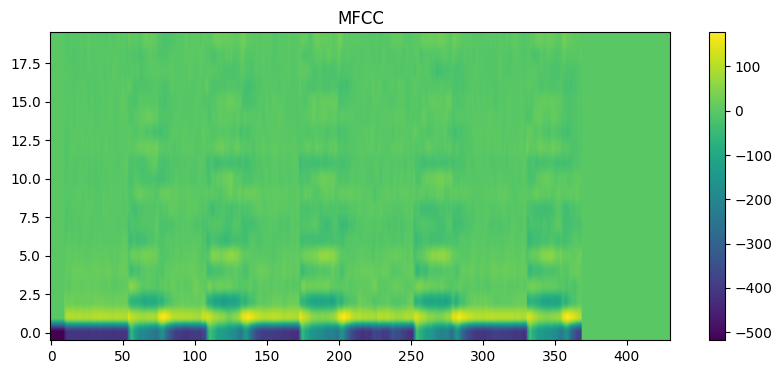

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4416 - loss: 1.2520 - val_accuracy: 0.6927 - val_loss: 0.7498
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7484 - loss: 0.6263 - val_accuracy: 0.7849 - val_loss: 0.6078
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8076 - loss: 0.4927 - val_accuracy: 0.8227 - val_loss: 0.5342
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8360 - loss: 0.4210 - val_accuracy: 0.8723 - val_loss: 0.3251
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8579 - loss: 0.3460 - val_accuracy: 0.8203 - val_loss: 0.4977
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8810 - loss: 0.2970 - val_accuracy: 0.8511 - val_loss: 0.3771
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8976 - loss: 0.2535 - val_accuracy: 0.8440 - val_loss: 0.4665
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.8877 - loss: 0.3097
Test accuracy: 0.87234

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import random
import tensorflow as tf

# 랜덤 시드 설정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy4',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy5',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/augmented(1)',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/add_noise',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/change_speed',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/pitch_shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/time_stretch',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid4',
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs, sr=22050):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs, sr=sr)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # CNN은 4D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

# 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(n_mfcc, fixed_sequence_length, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Reshape((fixed_sequence_length // 8, (n_mfcc // 8) * 128)),
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/0619_batchmax().keras')


In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 새로운 데이터 디렉토리 경로
new_data_dir = '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy5'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 모델 불러오기
model_path = '/content/drive/MyDrive/Colab Notebooks/saved_model/0619_batchmax(2143).keras'
model = load_model(model_path)

# 클래스 레이블
class_labels_unique = ['정상', 'others', '심부전', '천식']

# 새로운 데이터를 로드하고 MFCC로 변환하는 함수
def process_new_data(file_path, sr=22050):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if (pad_width := fixed_sequence_length - mfcc.shape[1]) > 0:
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_sequence_length]

    return np.expand_dims(mfcc, axis=-1)

# 디렉토리 내의 모든 파일에 대해 예측 수행
def predict_from_directory(data_dir):
    predictions = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            mfcc = process_new_data(file_path, sr=sr)
            if mfcc is not None:
                mfcc = np.expand_dims(mfcc, axis=0)  # 배치 차원 추가
                prediction = model.predict(mfcc)
                predicted_class = class_labels_unique[np.argmax(prediction)]
                predictions.append((file_name, predicted_class))
                print(f"File: {file_name}, Predicted class: {predicted_class}")
    return predictions

# 예측 수행
predictions = predict_from_directory(new_data_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
File: 2(250).wav, Predicted class: 천식
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
File: 2(255).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
File: 2(260).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
File: 2(265).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
File: 2(270).wav, Predicted class: 천식
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
File: 2(275).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
File: 2(280).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
File: 2(285).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
File: 2(290).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
File: 2(295).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
File: 2(300).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
File: 2(305).wav, Predicted class: 정상
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
File: 2(310).wav, Predicted class: 정상
1/1

In [ ]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 모델 불러오기
model_path = '/content/drive/MyDrive/Colab Notebooks/saved_model/0619_batchmax(2143).keras'
model = load_model(model_path)

# 클래스 레이블
class_labels_unique = ['심부전', '천식', '정상', 'others']

# 새로운 데이터를 로드하고 MFCC로 변환하는 함수
def process_new_data(file_path, sr=22050):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if (pad_width := fixed_sequence_length - mfcc.shape[1]) > 0:
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_sequence_length]

    return np.expand_dims(mfcc, axis=-1)

# 단일 파일에 대해 예측 수행
def predict_single_file(file_path):
    mfcc = process_new_data(file_path, sr=sr)
    if mfcc is not None:
        mfcc = np.expand_dims(mfcc, axis=0)  # 배치 차원 추가
        prediction = model.predict(mfcc)
        predicted_class = class_labels_unique[np.argmax(prediction)]

        # 예측 결과 형식화하여 출력
        print(f"File: {file_path.split('/')[-1]}")
        print(f"Predicted label: {predicted_class}")
        print(f"Predictions: {prediction.tolist()}")

        return predicted_class
    else:
        print("MFCC 처리 중 오류가 발생했습니다.")
        return None

# 예측할 파일 경로
single_file_path = '/content/drive/MyDrive/Colab Notebooks/voicedata/지인기침/ja.wav'

# 예측 수행
predicted_class = predict_single_file(single_file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: ja.wav
Predicted label: 천식
Predictions: [[0.30527567863464355, 0.48309409618377686, 0.002353025134652853, 0.20927713811397552]]


In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.1


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt

# 저장된 모델 로드
model_path = '/content/drive/MyDrive/Colab Notebooks/saved_model/0619_batchmax(2143).keras'
model = tf.keras.models.load_model(model_path)

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이
sr = 22050  # 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 클래스 레이블 로드
class_labels_unique = ['정상', '천식', '심부전', 'others']  # 실제 클래스 레이블로 업데이트

# 단일 오디오 파일 전처리 함수
def preprocess_audio(file_path, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이 조정
    if mfcc.shape[1] < fixed_sequence_length:
        pad_width = fixed_sequence_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_sequence_length]

    mfcc = np.expand_dims(mfcc, axis=-1)  # 채널 차원 추가
    return np.array([mfcc])

# 예측할 오디오 파일 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT/2(203).wav'

# 입력 오디오 파일 전처리
X_new = preprocess_audio(file_path, sr=sr)

# 예측 수행
predictions = model.predict(X_new)
predicted_label = class_labels_unique[np.argmax(predictions)]
predicted_probabilities = predictions[0]

# 결과 출력
print(f"파일: {os.path.basename(file_path)}")
print(f"예측된 레이블: {predicted_label}")
print(f"예측 확률: {predicted_probabilities}")





1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
파일: 2(203).wav
예측된 레이블: 정상
예측 확률: [0.7821583  0.05501164 0.00466275 0.15816727]
